In [1]:
from detectron2.utils.logger import setup_logger

setup_logger()

from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer

import os
import pickle
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2 import model_zoo

from detectron2.utils.visualizer import ColorMode

import random
import cv2
import matplotlib.pyplot as plt



config_file_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
checkpoint_url = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

output_dir = "./output_yolo2/segmentation"
num_class = 4

device = "cuda"


test_dataset_name = "LP_test"
test_images_path = r"C:\elicetrain\detectron2_custom_dataset\shuffled_images"
test_json_annot_path = r"C:\elicetrain\detectron2_custom_dataset\shuffled_labels_yolo_coco_bb.json"

cfg_svae_path = "IS_cfg_yolo.pikle"


if test_dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(test_dataset_name)
    MetadataCatalog.remove(test_dataset_name)


register_coco_instances(name=test_dataset_name, metadata={},
                        json_file=test_json_annot_path, image_root=test_images_path)


In [5]:
def evaluate_model(predictor, dataset):
    pixel_accuracies = []
    ious_per_class = [[] for _ in range(2)]  # 두 클래스: "parking space"와 "driveable space"
    aps_per_class = [[] for _ in range(2)]
    aps_50_per_class = [[] for _ in range(2)]  # IoU 0.5 이상에서의 AP

    for i, data in enumerate(dataset):
        img = cv2.imread(data["file_name"])  # 이미지 로드
        annotations = data["annotations"]
        true_class_ids = np.array([anno["category_id"] for anno in annotations])  # Ground truth class IDs

        # 모델 예측 수행
        outputs = predictor(img)
        pred_masks = outputs["instances"].pred_masks.to("cpu").numpy()
        pred_class_ids = outputs["instances"].pred_classes.to("cpu").numpy()

        if len(pred_masks) > 0:
            pred_mask = pred_masks[0]  # 첫 번째 마스크 사용
        else:
            pred_mask = np.zeros((img.shape[0], img.shape[1]), dtype=bool)  # 빈 마스크 생성

        # 픽셀 정확도 계산 (여기서는 참고용, 실제 의미는 다를 수 있음)
        true_mask = np.zeros((img.shape[0], img.shape[1]), dtype=bool)
        pixel_accuracy = accuracy_score(true_mask.flatten(), pred_mask.flatten())
        pixel_accuracies.append(pixel_accuracy)

        # 각 클래스별로 IoU 및 AP 계산 ("parking space" = 0, "driveable space" = 1)
        for class_id, class_name in enumerate(["parking space", "driveable space"]):
            true_class_mask = (true_class_ids == class_id).astype(int)  # 이진 값으로 변환
            pred_class_mask = (pred_class_ids == class_id).astype(int)  # 이진 값으로 변환

            # 길이 확인 후 조정
            if len(true_class_mask) != len(pred_class_mask):
                min_len = min(len(true_class_mask), len(pred_class_mask))
                true_class_mask = true_class_mask[:min_len]
                pred_class_mask = pred_class_mask[:min_len]

            # IoU 계산
            if len(pred_class_mask) > 0 and np.sum(pred_class_mask) > 0:
                iou = jaccard_score(true_class_mask.flatten(), pred_class_mask.flatten(), average="binary")
                ious_per_class[class_id].append(iou)

                # IoU 0.5 이상일 때만 AP 계산
                if iou >= 0.5:
                    if np.sum(true_class_mask) > 0 and np.sum(pred_class_mask) > 0:
                        precision, recall, _ = precision_recall_curve(true_class_mask.flatten(), pred_class_mask.flatten(), pos_label=1)
                        if len(recall) > 0 and len(precision) > 0:
                            ap = auc(recall, precision)
                            aps_50_per_class[class_id].append(ap)

            # 모든 IoU에서 AP 계산
            if np.sum(true_class_mask) > 0 and np.sum(pred_class_mask) > 0:
                precision, recall, _ = precision_recall_curve(true_class_mask.flatten(), pred_class_mask.flatten(), pos_label=1)
                if len(recall) > 0 and len(precision) > 0:
                    ap = auc(recall, precision)
                    aps_per_class[class_id].append(ap)

    # 클래스별 IoU 및 AP 평균 계산
    mean_ious = [np.mean(iou_list) if len(iou_list) > 0 else 0 for iou_list in ious_per_class]
    mean_aps = [np.mean(ap_list) if len(ap_list) > 0 else 0 for ap_list in aps_per_class]
    mean_aps_50 = [np.mean(ap_list) if len(ap_list) > 0 else 0 for ap_list in aps_50_per_class]

    # mIoU 및 mAP 계산
    miou = np.mean(mean_ious)
    map_value = np.mean(mean_aps)
    map_50_value = np.mean(mean_aps_50)

    # 결과 출력
    print(f"Pixel Accuracy: {np.mean(pixel_accuracies)}")
    print(f"mIoU: {miou}")
    print(f"mAP: {map_value}")
    print(f"mAP@IoU 0.5: {map_50_value}")

    return {
        'pixel_accuracy': np.mean(pixel_accuracies),
        'class_iou': mean_ious,
        'class_ap': mean_aps,
        'class_ap_50': mean_aps_50,
        'miou': miou,
        'map': map_value,
        'map_50': map_50_value,
        'iou_per_class': ious_per_class,
        'aps_per_class': aps_per_class,
        'aps50_per_class': aps_50_per_class
    }


추론 및 후처리

[09/07 19:20:28 d2.data.datasets.coco]: Loading C:\elicetrain\detectron2_custom_dataset\shuffled_labels_yolo_coco_bb.json takes 3.98 seconds.
[09/07 19:20:28 d2.data.datasets.coco]: Loaded 14853 images in COCO format from C:\elicetrain\detectron2_custom_dataset\shuffled_labels_yolo_coco_bb.json
WARNING [09/07 19:20:30 d2.data.datasets.coco]: Filtered out 70 instances without valid segmentation. There might be issues in your dataset generation process.  Please check https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html carefully
Epoch 1/10
[09/07 19:20:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:\elicetrain\detectron2_custom_dataset\output_yolo2\segmentation\model_0044999.pth ...


c:\Users\jyj\anaconda3\envs\detectron_env\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=

[09/07 19:20:31 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-101.pkl ...
[09/07 19:20:31 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[09/07 19:20:32 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 105


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

Pixel Accuracy: 0.950512912765524
mIoU: 0.20901830853089653
mAP: 0.35619865140979756
mAP@IoU 0.5: 0.9173850450961303
Epoch 2/10
[09/07 20:22:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:\elicetrain\detectron2_custom_dataset\output_yolo2\segmentation\model_0089999.pth ...


c:\Users\jyj\anaconda3\envs\detectron_env\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=

[09/07 20:22:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-101.pkl ...
[09/07 20:22:48 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[09/07 20:22:48 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 105


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

Pixel Accuracy: 0.9433318043640952
mIoU: 0.22695812166053886
mAP: 0.3721034118350569
mAP@IoU 0.5: 0.9190213485218648
Epoch 3/10
[09/07 21:23:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:\elicetrain\detectron2_custom_dataset\output_yolo2\segmentation\model_0134999.pth ...


c:\Users\jyj\anaconda3\envs\detectron_env\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=

[09/07 21:23:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-101.pkl ...
[09/07 21:23:36 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[09/07 21:23:36 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 105


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

Pixel Accuracy: 0.913831695971602
mIoU: 0.2986925671347467
mAP: 0.4445470247591735
mAP@IoU 0.5: 0.92525970144011
Epoch 4/10
[09/07 22:24:11 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:\elicetrain\detectron2_custom_dataset\output_yolo2\segmentation\model_0179999.pth ...


c:\Users\jyj\anaconda3\envs\detectron_env\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=

[09/07 22:24:12 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-101.pkl ...
[09/07 22:24:12 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[09/07 22:24:12 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 105


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

Pixel Accuracy: 0.9240978573040488
mIoU: 0.2719932653265108
mAP: 0.42003307657963285
mAP@IoU 0.5: 0.9184678146959679
Epoch 5/10
[09/07 23:24:51 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:\elicetrain\detectron2_custom_dataset\output_yolo2\segmentation\model_0224999.pth ...


c:\Users\jyj\anaconda3\envs\detectron_env\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=

[09/07 23:24:51 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-101.pkl ...
[09/07 23:24:51 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[09/07 23:24:52 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 105


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

Pixel Accuracy: 0.9500639530970901
mIoU: 0.21933982491471554
mAP: 0.36549573650210293
mAP@IoU 0.5: 0.9126692197238259
Epoch 6/10
[09/08 00:25:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:\elicetrain\detectron2_custom_dataset\output_yolo2\segmentation\model_0269999.pth ...


c:\Users\jyj\anaconda3\envs\detectron_env\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=

[09/08 00:25:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-101.pkl ...
[09/08 00:25:34 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[09/08 00:25:34 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 105


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

Pixel Accuracy: 0.9207239411380708
mIoU: 0.2824243863092776
mAP: 0.4251610542768623
mAP@IoU 0.5: 0.925386008519197
Epoch 7/10
[09/08 01:26:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:\elicetrain\detectron2_custom_dataset\output_yolo2\segmentation\model_0314999.pth ...


c:\Users\jyj\anaconda3\envs\detectron_env\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=

[09/08 01:26:51 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-101.pkl ...
[09/08 01:26:51 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[09/08 01:26:51 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 105


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

Pixel Accuracy: 0.9458797515809251
mIoU: 0.22549690038383596
mAP: 0.3721836690360153
mAP@IoU 0.5: 0.910734149819663
Epoch 8/10
[09/08 02:27:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:\elicetrain\detectron2_custom_dataset\output_yolo2\segmentation\model_0359999.pth ...


c:\Users\jyj\anaconda3\envs\detectron_env\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=

[09/08 02:27:07 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-101.pkl ...
[09/08 02:27:07 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[09/08 02:27:07 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 105


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

Pixel Accuracy: 0.948000264084946
mIoU: 0.20294664003174595
mAP: 0.3484377028445943
mAP@IoU 0.5: 0.9156223794964795
Epoch 9/10
[09/08 03:27:15 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:\elicetrain\detectron2_custom_dataset\output_yolo2\segmentation\model_0404999.pth ...


c:\Users\jyj\anaconda3\envs\detectron_env\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=

[09/08 03:27:16 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-101.pkl ...
[09/08 03:27:16 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[09/08 03:27:16 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 105


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

Pixel Accuracy: 0.9580787399709022
mIoU: 0.19274887310027516
mAP: 0.341030880979843
mAP@IoU 0.5: 0.9068812219139631
Epoch 10/10
[09/08 04:27:40 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:\elicetrain\detectron2_custom_dataset\output_yolo2\segmentation\model_0449999.pth ...


c:\Users\jyj\anaconda3\envs\detectron_env\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=

[09/08 04:27:41 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-101.pkl ...
[09/08 04:27:41 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[09/08 04:27:41 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 105


Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

Pixel Accuracy: 0.9479860995198938
mIoU: 0.22231143896973626
mAP: 0.36978843069337364
mAP@IoU 0.5: 0.9134413853470895


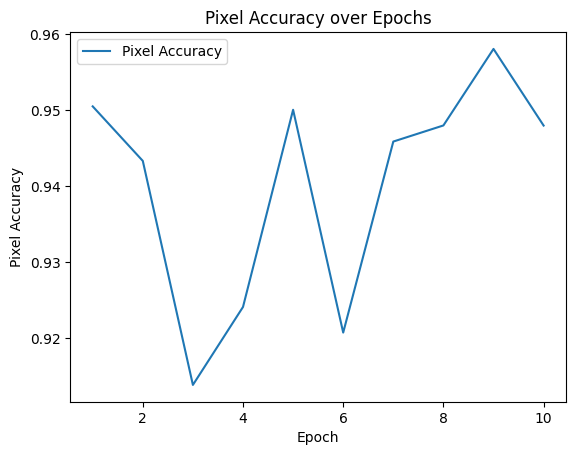

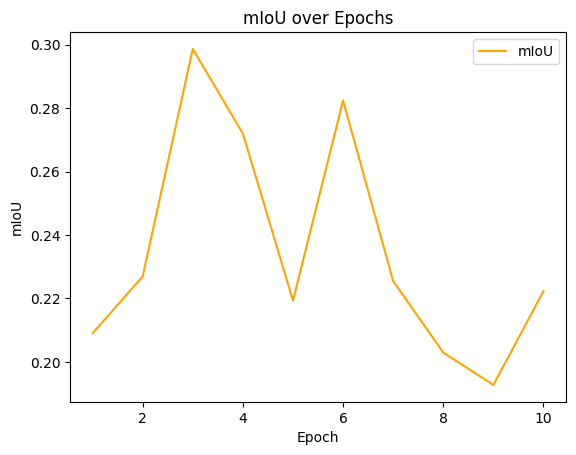

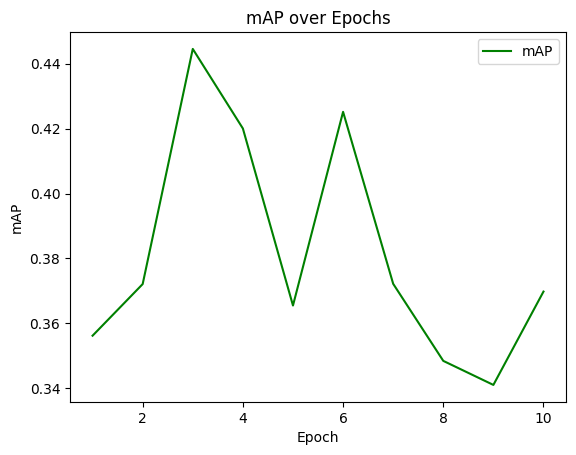

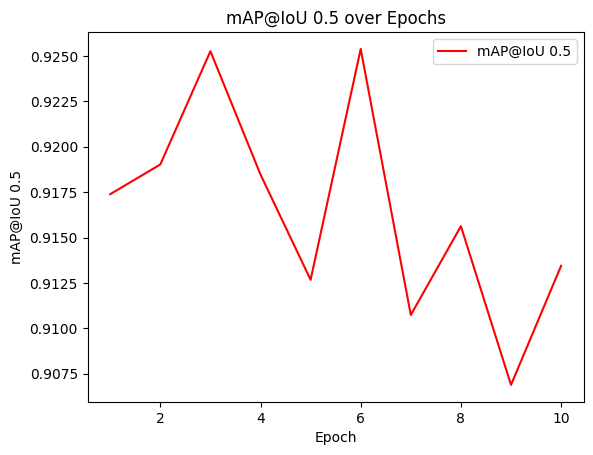

In [21]:
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
import numpy as np 
from sklearn.metrics import jaccard_score, precision_recall_curve, auc, accuracy_score
import torch
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling.roi_heads import FastRCNNOutputLayers, MaskRCNNConvUpsampleHead
from detectron2.modeling import build_model
import os

# 각 epoch마다 성능 지표를 저장할 리스트 초기화
pixel_accuracies = []
miou_values = []
map_values = []
map_50_values = []

# 설정
iterations_per_epoch = 45000
total_epochs = 10

# 기본적인 cfg 설정
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # 클래스 수 설정
cfg.MODEL.DEVICE = "cuda"  # GPU 설정
dataset_val = DatasetCatalog.get(test_dataset_name)

# 10 epoch 동안 모델 평가
for epoch in range(total_epochs):
    print(f"Epoch {epoch + 1}/{total_epochs}")

    # 매 epoch마다 새로운 모델 가중치 파일을 지정 (여기서는 가중치 파일명에 epoch 숫자를 포함)
    weight_file = f"C:\\elicetrain\\detectron2_custom_dataset\\output_num9_batch2\\segmentation\\model_{(epoch+1)*45000 - 1:07d}.pth"
    
    if not os.path.exists(weight_file):
        print(f"가중치 파일 {weight_file}을 찾을 수 없습니다. 스킵합니다.")
        continue

    # 새로운 모델 객체 생성 및 가중치 로드
    model = build_model(cfg)  # 모델 빌드
    checkpointer = DetectionCheckpointer(model)
    checkpointer.load(weight_file)  # 가중치만 로드
    model.eval()  # **평가 모드로 전환**

    # 새로 로드한 모델로 predictor 생성
    predictor = DefaultPredictor(cfg)
    predictor.model = model  # 로드한 가중치를 포함한 모델 사용

    # 한 epoch이 끝난 후 evaluate_model() 함수 호출하여 평가
    results = evaluate_model(predictor, dataset_val)

    # 각 지표 저장
    pixel_accuracies.append(results['pixel_accuracy'])
    miou_values.append(results['miou'])
    map_values.append(results['map'])
    map_50_values.append(results['map_50'])

# 결과 시각화
epochs = range(1, total_epochs + 1)

# Pixel Accuracy 그래프
plt.figure()
plt.plot(epochs, pixel_accuracies, label="Pixel Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.title('Pixel Accuracy over Epochs')
plt.legend()
plt.show()

# mIoU 그래프
plt.figure()
plt.plot(epochs, miou_values, label="mIoU", color='orange')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('mIoU over Epochs')
plt.legend()
plt.show()

# mAP 그래프
plt.figure()
plt.plot(epochs, map_values, label="mAP", color='green')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('mAP over Epochs')
plt.legend()
plt.show()

# mAP@IoU 0.5 그래프
plt.figure()
plt.plot(epochs, map_50_values, label="mAP@IoU 0.5", color='red')
plt.xlabel('Epoch')
plt.ylabel('mAP@IoU 0.5')
plt.title('mAP@IoU 0.5 over Epochs')
plt.legend()
plt.show()


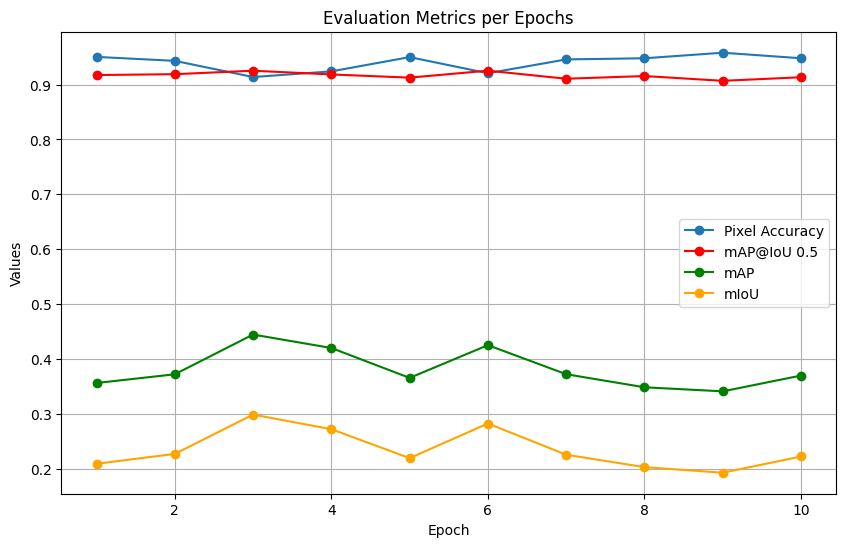

In [2]:
import matplotlib.pyplot as plt
epochs = range(1, 11)
pixel_accuracies =[0.9505, 0.9433, 0.9138, 0.9241, 0.9501, 0.9207, 0.9459, 0.9480, 0.9581, 0.9480]
map_50_values =[0.9174, 0.9190, 0.9253, 0.9185, 0.9127, 0.9254, 0.9107, 0.9156, 0.9069, 0.9134]
map_values =[0.3562, 0.3721, 0.4445, 0.4200, 0.3655, 0.4252, 0.3722, 0.3484, 0.3410, 0.3698]
miou_values =[0.2090, 0.2270, 0.2987, 0.2720, 0.2193, 0.2824, 0.2255, 0.2029, 0.1927, 0.2223]

# 하나의 그래프에 여러 지표 그리기
plt.figure(figsize=(10, 6))

# 각 지표를 하나의 그래프에 그리기
plt.plot(epochs, pixel_accuracies, label="Pixel Accuracy", marker='o')
plt.plot(epochs, map_50_values, label="mAP@IoU 0.5", marker='o', color='red')
plt.plot(epochs, map_values, label="mAP", marker='o', color='green')
plt.plot(epochs, miou_values, label="mIoU", marker='o', color='orange')



# 그래프 설정
plt.xlabel('Epoch')
plt.ylabel('Values')
plt.title('Evaluation Metrics per Epochs')
plt.legend()
plt.grid(True)

# 그래프 출력
plt.show()


In [6]:
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
import numpy as np 
from sklearn.metrics import jaccard_score, precision_recall_curve, auc, accuracy_score
import torch
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling.roi_heads import FastRCNNOutputLayers, MaskRCNNConvUpsampleHead
from detectron2.modeling import build_model
import os



cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))

cfg.MODEL.WEIGHTS = r"C:\elicetrain\detectron2_custom_dataset\output_yolo3\segmentation\model_final.pth"


# 예측에 사용할 score threshold 설정
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

# 데이터셋의 클래스 수에 맞게 설정 (훈련 시 사용한 설정과 동일해야 함)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # 예: 80 classes in COCO

# GPU가 여러 개라면 이를 설정 (기본적으로는 1)
cfg.MODEL.DEVICE = "cuda"  # 또는 "cpu"

predictor = DefaultPredictor(cfg)



[09/09 11:43:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:\elicetrain\detectron2_custom_dataset\output_yolo3\segmentation\model_final.pth ...


c:\Users\jyj\anaconda3\envs\detectron_env\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=

In [7]:
dataset_val = DatasetCatalog.get(test_dataset_name)  # Validation dataset을 가져옵니다.
results10 = evaluate_model(predictor, dataset_val)

[09/09 11:44:41 d2.data.datasets.coco]: Loading C:\elicetrain\detectron2_custom_dataset\shuffled_labels_yolo_coco_bb.json takes 3.10 seconds.
[09/09 11:44:41 d2.data.datasets.coco]: Loaded 14853 images in COCO format from C:\elicetrain\detectron2_custom_dataset\shuffled_labels_yolo_coco_bb.json
WARNING [09/09 11:44:42 d2.data.datasets.coco]: Filtered out 70 instances without valid segmentation. There might be issues in your dataset generation process.  Please check https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html carefully


c:\Users\jyj\anaconda3\envs\detectron_env\lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Pixel Accuracy: 0.9342624719745793
mIoU: 0.25989576531320824
mAP: 0.40747129710718
mAP@IoU 0.5: 0.9199907315692155
